In [41]:
# New Jupyter cell: load CSV and run quick sklearn/statsmodels/PyTorch workflow
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [42]:
# 1) Read CSV
csv_path = "avalon_nuclear.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found in working directory.")
df = pd.read_csv(csv_path)
print("Loaded:", df.shape)
display(df.head())

Loaded: (5000, 37)


,country,reactor_age_years,reactor_type_code,reactor_nominal_power_mw,load_factor_pct,population_within_30km,ambient_temp_c,co2_avoided_tons_per_hour,core_temp_c,coolant_pressure_bar,...,seismic_activity_index,cyber_attack_score,avalon_raw_risk_score,avalon_learned_reward_score,true_risk_level,avalon_evac_recommendation,avalon_shutdown_recommendation,human_override,incident_occurred,year
0,Hungary,23,4,756.331438,80.615726,1469895,14.216397,0.243889,281.072631,165.077514,...,0.161198,25.741555,1.115604,6.672804,3,1,1,0,0,2019
1,Croatia,32,4,1037.033725,91.116016,58077,5.261005,0.377962,288.553053,164.086104,...,2.893515,15.320646,2.649434,6.929254,3,1,1,0,0,2005
2,Norway,10,1,996.889393,85.375634,295678,19.442758,0.340440,316.605339,163.793783,...,6.042242,0.000000,1.340012,6.353381,3,0,1,0,0,1998
3,Belgium,10,2,1343.544270,83.479811,1354356,11.607403,0.448635,311.572273,145.419473,...,3.050245,18.325252,2.497715,6.684715,3,1,1,0,0,2011
4,Poland,36,4,1180.737140,100.000000,1048119,22.148477,0.472295,293.877648,158.847971,...,7.251403,8.235052,1.204937,6.041739,3,0,1,0,0,2009


/var/folders/sz/wh59dnjs4p1_q_6lrs1m0sg40000gn/T/ipykernel_81278/1881417378.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette=colors, ax=ax,


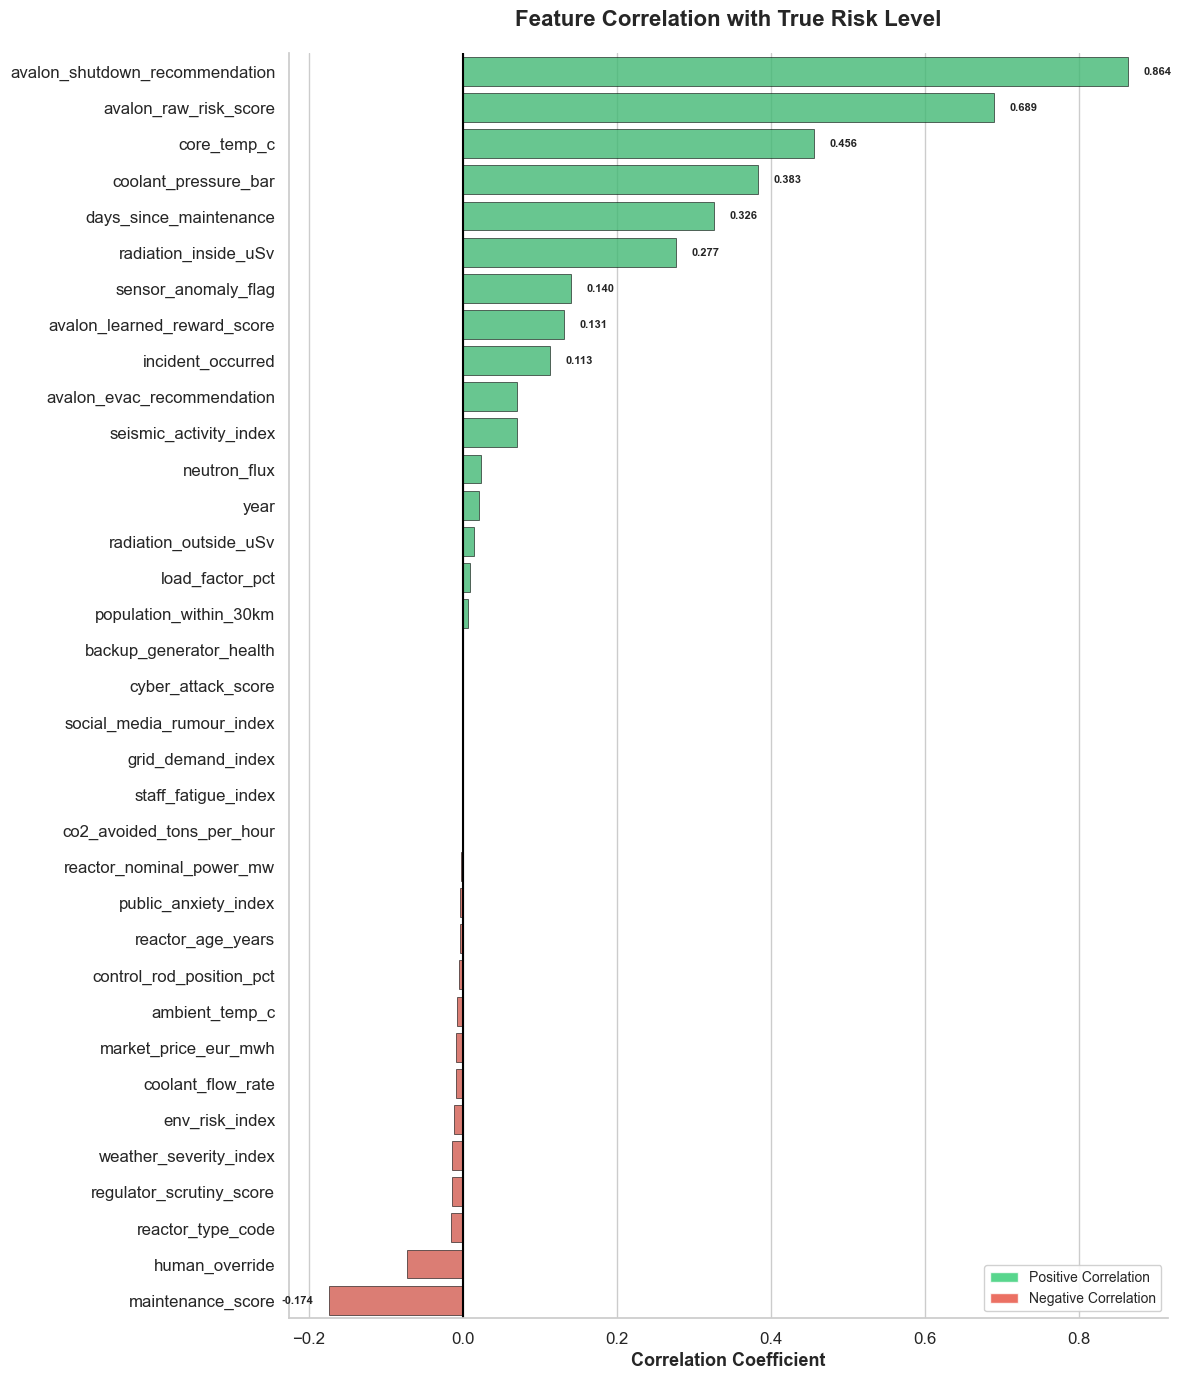


TOP 10 POSITIVE CORRELATIONS WITH TRUE_RISK_LEVEL
avalon_shutdown_recommendation    0.864048
avalon_raw_risk_score             0.689304
core_temp_c                       0.455898
coolant_pressure_bar              0.383200
days_since_maintenance            0.325880
radiation_inside_uSv              0.277288
sensor_anomaly_flag               0.140162
avalon_learned_reward_score       0.130891
incident_occurred                 0.112649
avalon_evac_recommendation        0.070883
Name: true_risk_level, dtype: float64

TOP 10 NEGATIVE CORRELATIONS WITH TRUE_RISK_LEVEL
control_rod_position_pct   -0.004672
ambient_temp_c             -0.007297
market_price_eur_mwh       -0.008366
coolant_flow_rate          -0.009343
env_risk_index             -0.011424
weather_severity_index     -0.014521
regulator_scrutiny_score   -0.014525
reactor_type_code          -0.015553
human_override             -0.073018
maintenance_score          -0.174401
Name: true_risk_level, dtype: float64


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for beautiful plots
sns.set_theme(style="whitegrid", palette="husl")
sns.set_context("notebook", font_scale=1.1)

# Select only numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=[np.number])

# Calculate correlations with true_risk_level
correlations = numerical_df.corr()['true_risk_level'].sort_values(ascending=False)

# Remove true_risk_level itself from the list
correlations = correlations.drop('true_risk_level')

# Create a beautiful horizontal bar plot using seaborn
plt.close('all')  # Close previous figures to prevent lag
fig, ax = plt.subplots(figsize=(12, 14))

# Create color palette
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in correlations.values]

# Use seaborn barplot
sns.barplot(x=correlations.values, y=correlations.index, palette=colors, ax=ax, 
            edgecolor='black', linewidth=0.5, alpha=0.8)

ax.set_xlabel('Correlation Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('')
ax.set_title('Feature Correlation with True Risk Level', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
sns.despine(top=True, right=True)

# Add value labels on bars
for i, val in enumerate(correlations.values):
    if abs(val) > 0.1:  # Only label significant correlations
        ax.text(val + (0.02 if val > 0 else -0.02), i, f'{val:.3f}', 
                va='center', ha='left' if val > 0 else 'right', fontsize=8, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', alpha=0.8, label='Positive Correlation'),
                   Patch(facecolor='#e74c3c', alpha=0.8, label='Negative Correlation')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

# Print top correlations
print("\n" + "="*60)
print("TOP 10 POSITIVE CORRELATIONS WITH TRUE_RISK_LEVEL")
print("="*60)
print(correlations.head(10))
print("\n" + "="*60)
print("TOP 10 NEGATIVE CORRELATIONS WITH TRUE_RISK_LEVEL")
print("="*60)
print(correlations.tail(10))

In [44]:
# Prepare data for modeling: 60% train, 20% validation, 20% test split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler

# Separate features and target
X = df.drop(['true_risk_level'], axis=1)
y = df['true_risk_level']

# Handle categorical variables (country) - encode it
le = LabelEncoder()
X_processed = X.copy()
if 'country' in X_processed.columns:
    X_processed['country'] = le.fit_transform(X_processed['country'])

# First split: 60% train, 40% temp (which will be split into 20% val, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: split the 40% into 50-50 (20% val, 20% test of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts().sort_index())

# Try different normalization techniques
print("\n" + "="*70)
print("     🔬 FEATURE NORMALIZATION COMPARISON 🔬")
print("="*70)

# 1. Standard Scaler (Z-score normalization)
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_val_standard = scaler_standard.transform(X_val)
X_test_standard = scaler_standard.transform(X_test)

# 2. MinMax Scaler (scales to [0, 1])
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_val_minmax = scaler_minmax.transform(X_val)
X_test_minmax = scaler_minmax.transform(X_test)

# 3. Robust Scaler (uses median and IQR, robust to outliers)
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_val_robust = scaler_robust.transform(X_val)
X_test_robust = scaler_robust.transform(X_test)

# Store for backwards compatibility
X_train_scaled = X_train_standard
X_val_scaled = X_val_standard
X_test_scaled = X_test_standard

print("\n✅ Created three normalized versions:")
print("   1. StandardScaler (Z-score): Mean=0, Std=1")
print("   2. MinMaxScaler: Scaled to [0, 1]")
print("   3. RobustScaler: Median-centered, robust to outliers")

Training set size: 3000 (60.0%)
Validation set size: 1000 (20.0%)
Test set size: 1000 (20.0%)

Target distribution in training set:
true_risk_level
0      80
1     253
2     594
3    2073
Name: count, dtype: int64

     🔬 FEATURE NORMALIZATION COMPARISON 🔬

✅ Created three normalized versions:
   1. StandardScaler (Z-score): Mean=0, Std=1
   2. MinMaxScaler: Scaled to [0, 1]
   3. RobustScaler: Median-centered, robust to outliers


In [45]:
# Logistic Regression with Lasso (L1) regularization
# Test different lambda (C) values - note: sklearn uses C = 1/lambda
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Range of C values (inverse of lambda)
# Smaller C = stronger regularization (larger lambda)
C_values = np.logspace(-3, 3, 50)  # From 0.001 to 1000
lambdas = 1 / C_values  # Convert to lambda for interpretation

# Store coefficients for each C value
coefficients = []
train_accuracies = []
val_accuracies = []

print("Training Lasso Logistic Regression models with varying regularization...")

for C in C_values:
    # Train logistic regression with L1 penalty (Lasso)
    model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='saga',  # saga solver supports L1 penalty
        max_iter=1000,
        random_state=42
        # Removed deprecated multi_class parameter - defaults to 'multinomial'
    )
    model.fit(X_train_scaled, y_train)
    
    # Store coefficients (average across classes for multiclass)
    coefficients.append(np.mean(np.abs(model.coef_), axis=0))
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    val_acc = accuracy_score(y_val, model.predict(X_val_scaled))
    
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

print(f"Completed training {len(C_values)} models")

Training Lasso Logistic Regression models with varying regularization...


/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/samuel/anacon

Completed training 50 models


/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


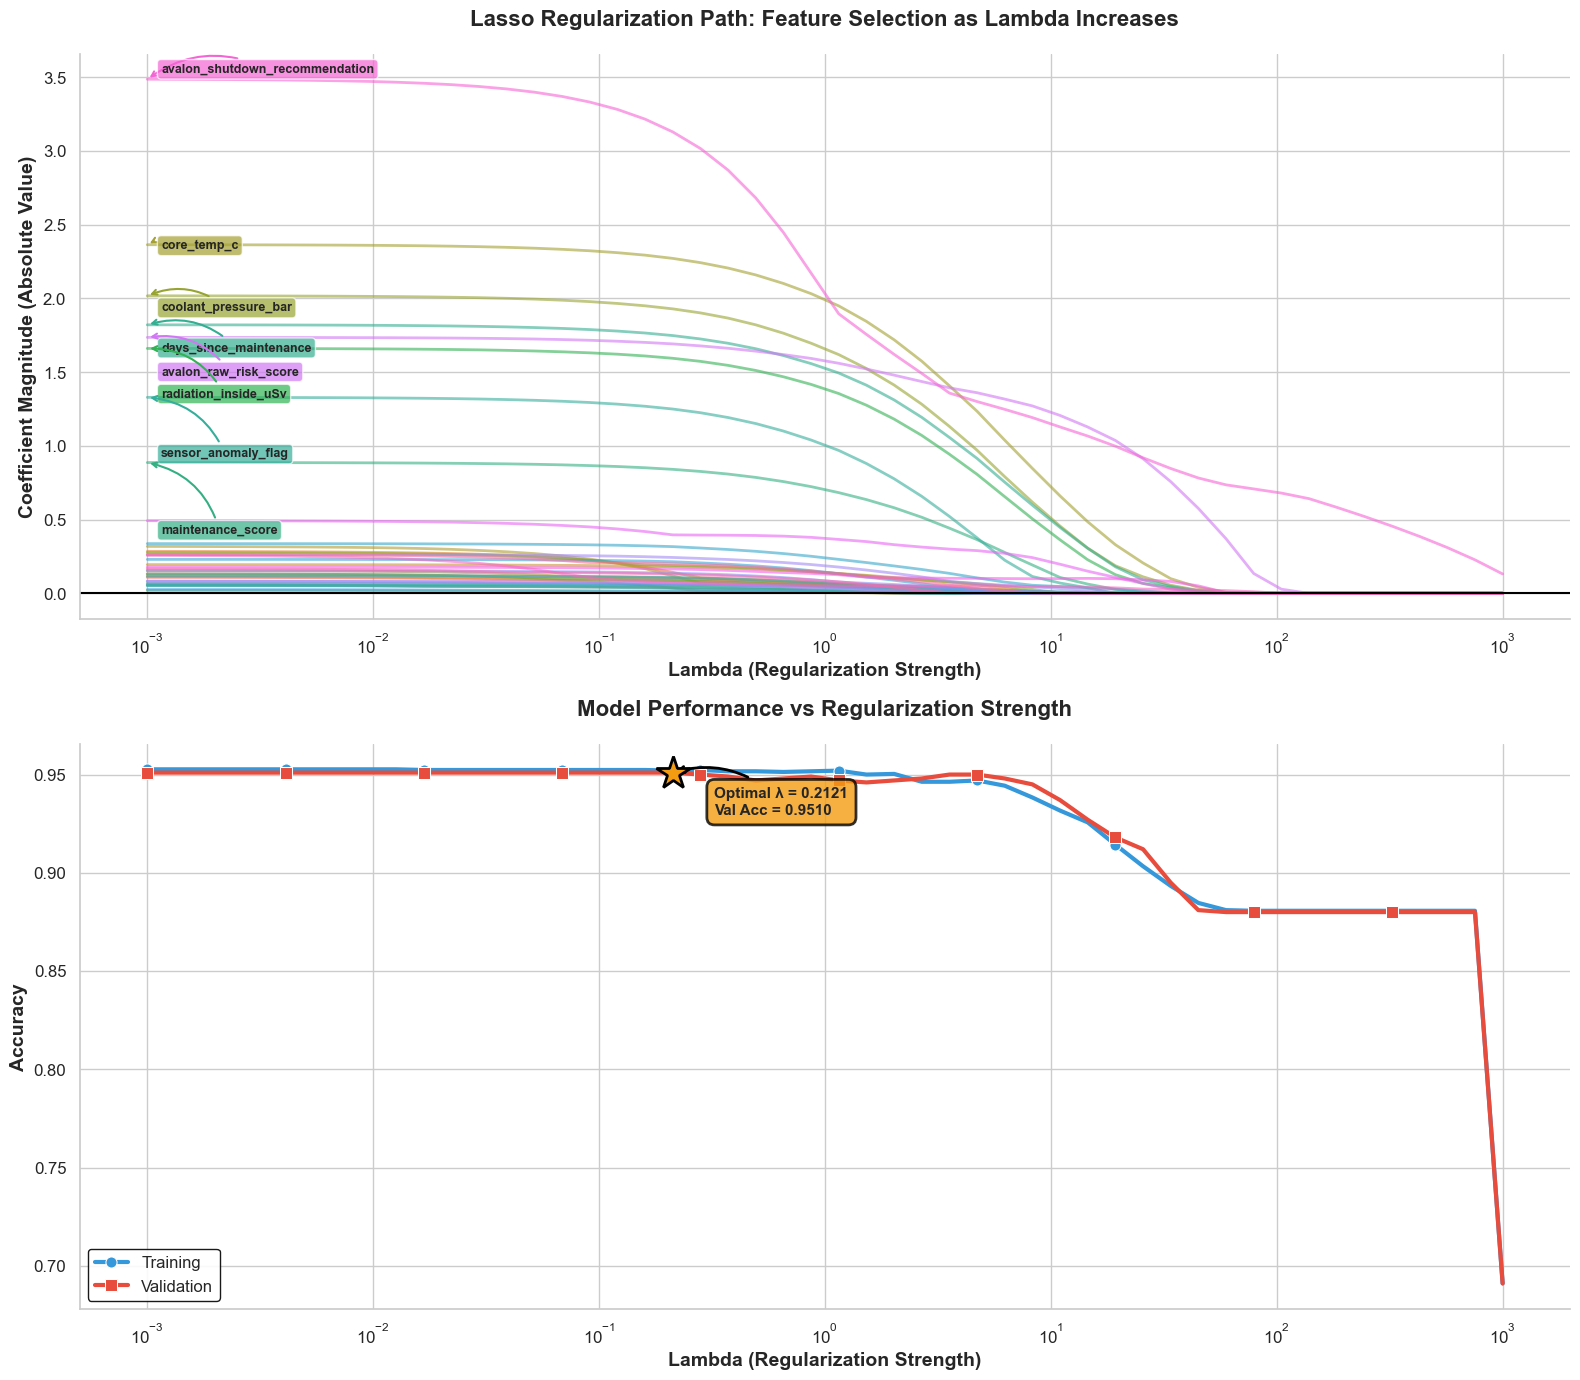


           🎯 OPTIMAL LASSO LOGISTIC REGRESSION MODEL 🎯

Best Validation Accuracy:      0.9510
Optimal Lambda:                0.212095
Optimal C (1/Lambda):          4.714866
Training Accuracy:             0.9520

           🏆 TOP 10 MOST IMPORTANT FEATURES 🏆

Rank   Feature Name                        Coefficient Magnitude
----------------------------------------------------------------------
1      avalon_shutdown_recommendation      3.1296              
2      core_temp_c                         2.2719              
3      coolant_pressure_bar                1.9295              
4      days_since_maintenance              1.7484              
5      avalon_raw_risk_score               1.6919              
6      radiation_inside_uSv                1.5943              
7      sensor_anomaly_flag                 1.2501              
8      maintenance_score                   0.8409              
9      avalon_learned_reward_score         0.3966              
10     public_anxiety_index

In [46]:
# Visualize the regularization path and model performance
plt.close('all')  # Close previous figures to prevent lag

coefficients_array = np.array(coefficients)
feature_names = X_train.columns

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# Plot 1: Coefficient paths as lambda increases using seaborn
ax1 = axes[0]

# Prepare data for seaborn lineplot
coef_df = pd.DataFrame(coefficients_array, columns=feature_names)
coef_df['lambda'] = lambdas

# Melt for seaborn format
coef_melted = coef_df.melt(id_vars=['lambda'], var_name='Feature', value_name='Coefficient')

# Plot using seaborn
sns.lineplot(data=coef_melted, x='lambda', y='Coefficient', hue='Feature', 
             ax=ax1, linewidth=2, alpha=0.6, legend=False)

ax1.set_xscale('log')
ax1.set_xlabel('Lambda (Regularization Strength)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Coefficient Magnitude (Absolute Value)', fontsize=14, fontweight='bold')
ax1.set_title('Lasso Regularization Path: Feature Selection as Lambda Increases', 
              fontsize=16, fontweight='bold', pad=20)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
sns.despine(ax=ax1)

# Annotate top features at the end
final_coef_idx = np.argsort(coefficients_array[-1])[-8:][::-1]  # Top 8 features
colors_palette = sns.color_palette("husl", len(feature_names))
for rank, idx in enumerate(final_coef_idx):
    y_pos = coefficients_array[-1, idx]
    ax1.annotate(feature_names[idx], 
                xy=(lambdas[-1], y_pos),
                xytext=(10, 5 - rank*8),
                textcoords='offset points',
                fontsize=9,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_palette[idx], alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                              color=colors_palette[idx], linewidth=1.5))

# Plot 2: Model accuracy vs lambda using seaborn
ax2 = axes[1]

# Prepare data for seaborn
accuracy_df = pd.DataFrame({
    'lambda': np.concatenate([lambdas, lambdas]),
    'Accuracy': np.concatenate([train_accuracies, val_accuracies]),
    'Dataset': ['Training']*len(lambdas) + ['Validation']*len(lambdas)
})

sns.lineplot(data=accuracy_df, x='lambda', y='Accuracy', hue='Dataset', 
             style='Dataset', markers=['o', 's'], dashes=False, 
             linewidth=3, markersize=8, markevery=5, ax=ax2,
             palette={'Training': '#3498db', 'Validation': '#e74c3c'})

ax2.set_xscale('log')
ax2.set_xlabel('Lambda (Regularization Strength)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax2.set_title('Model Performance vs Regularization Strength', fontsize=16, fontweight='bold', pad=20)
sns.despine(ax=ax2)

# Mark the best validation accuracy with a star
best_idx = np.argmax(val_accuracies)
ax2.plot(lambdas[best_idx], val_accuracies[best_idx], marker='*', markersize=25, 
         color='#f39c12', markeredgecolor='black', markeredgewidth=2, zorder=10)

# Add annotation for best point
ax2.annotate(f'Optimal λ = {lambdas[best_idx]:.4f}\nVal Acc = {val_accuracies[best_idx]:.4f}',
            xy=(lambdas[best_idx], val_accuracies[best_idx]),
            xytext=(30, -30),
            textcoords='offset points',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#f39c12', alpha=0.8, edgecolor='black', linewidth=2),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                          color='black', linewidth=2))

ax2.legend(fontsize=12, loc='lower left', framealpha=0.9, edgecolor='black')

plt.tight_layout()
plt.show()

# Print beautiful summary of best model
print("\n" + "="*70)
print("           🎯 OPTIMAL LASSO LOGISTIC REGRESSION MODEL 🎯")
print("="*70)
print(f"\n{'Best Validation Accuracy:':<30} {val_accuracies[best_idx]:.4f}")
print(f"{'Optimal Lambda:':<30} {lambdas[best_idx]:.6f}")
print(f"{'Optimal C (1/Lambda):':<30} {C_values[best_idx]:.6f}")
print(f"{'Training Accuracy:':<30} {train_accuracies[best_idx]:.4f}")

print("\n" + "="*70)
print("           🏆 TOP 10 MOST IMPORTANT FEATURES 🏆")
print("="*70)
best_coefs = coefficients_array[best_idx]
top_features_idx = np.argsort(best_coefs)[-10:][::-1]

print(f"\n{'Rank':<6} {'Feature Name':<35} {'Coefficient Magnitude':<20}")
print("-"*70)
for rank, idx in enumerate(top_features_idx, 1):
    print(f"{rank:<6} {feature_names[idx]:<35} {best_coefs[idx]:<20.4f}")
print("="*70)


     📊 FINAL LASSO LOGISTIC REGRESSION MODEL PERFORMANCE 📊

Dataset              Accuracy        Samples   
----------------------------------------------------------------------
Training             0.9520          3000      
Validation           0.9510          1000      
Test                 0.9380          1000      

               📋 CLASSIFICATION REPORT (Test Set) 📋
              precision    recall  f1-score   support

           0       0.83      0.56      0.67        27
           1       0.65      0.69      0.67        85
           2       0.88      0.88      0.88       198
           3       0.99      1.00      1.00       690

    accuracy                           0.94      1000
   macro avg       0.84      0.78      0.80      1000
weighted avg       0.94      0.94      0.94      1000



/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


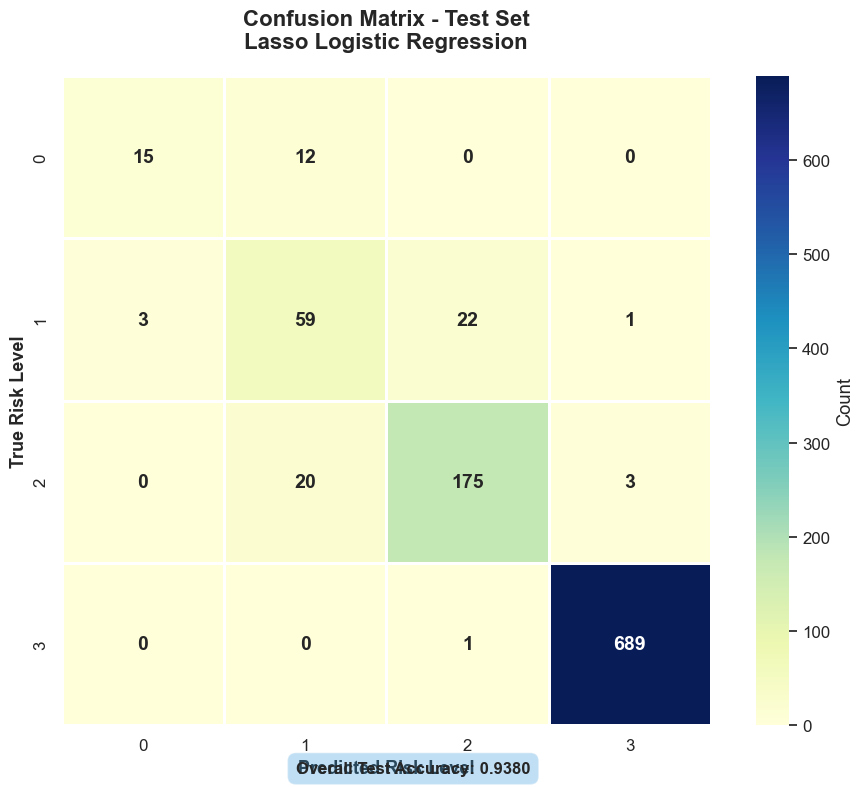

In [47]:
# Train final model with optimal hyperparameters and evaluate on test set
plt.close('all')  # Close previous figures to prevent lag

best_C = C_values[best_idx]

final_model = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='saga',
    max_iter=1000,
    random_state=42
    # Removed deprecated multi_class parameter - defaults to 'multinomial'
)

final_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = final_model.predict(X_train_scaled)
y_val_pred = final_model.predict(X_val_scaled)
y_test_pred = final_model.predict(X_test_scaled)

# Evaluation
print("\n" + "="*70)
print("     📊 FINAL LASSO LOGISTIC REGRESSION MODEL PERFORMANCE 📊")
print("="*70)
print(f"\n{'Dataset':<20} {'Accuracy':<15} {'Samples':<10}")
print("-"*70)
print(f"{'Training':<20} {accuracy_score(y_train, y_train_pred):<15.4f} {len(y_train):<10}")
print(f"{'Validation':<20} {accuracy_score(y_val, y_val_pred):<15.4f} {len(y_val):<10}")
print(f"{'Test':<20} {accuracy_score(y_test, y_test_pred):<15.4f} {len(y_test):<10}")
print("="*70)

print("\n" + "="*70)
print("               📋 CLASSIFICATION REPORT (Test Set) 📋")
print("="*70)
print(classification_report(y_test, y_test_pred))

# Beautiful confusion matrix using seaborn
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(y_test, y_test_pred)

# Use seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white', square=True, ax=ax,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax.set_title('Confusion Matrix - Test Set\nLasso Logistic Regression', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Risk Level', fontsize=13, fontweight='bold')
ax.set_ylabel('True Risk Level', fontsize=13, fontweight='bold')

# Add accuracy text
test_acc = accuracy_score(y_test, y_test_pred)
fig.text(0.5, 0.02, f'Overall Test Accuracy: {test_acc:.4f}', 
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#3498db', alpha=0.3))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


     📊 NORMALIZATION TECHNIQUE COMPARISON 📊

StandardScaler:
  Train: 0.9537 | Val: 0.9490 | Test: 0.9420

MinMaxScaler:
  Train: 0.9533 | Val: 0.9490 | Test: 0.9360

RobustScaler:
  Train: 0.9553 | Val: 0.9480 | Test: 0.9440


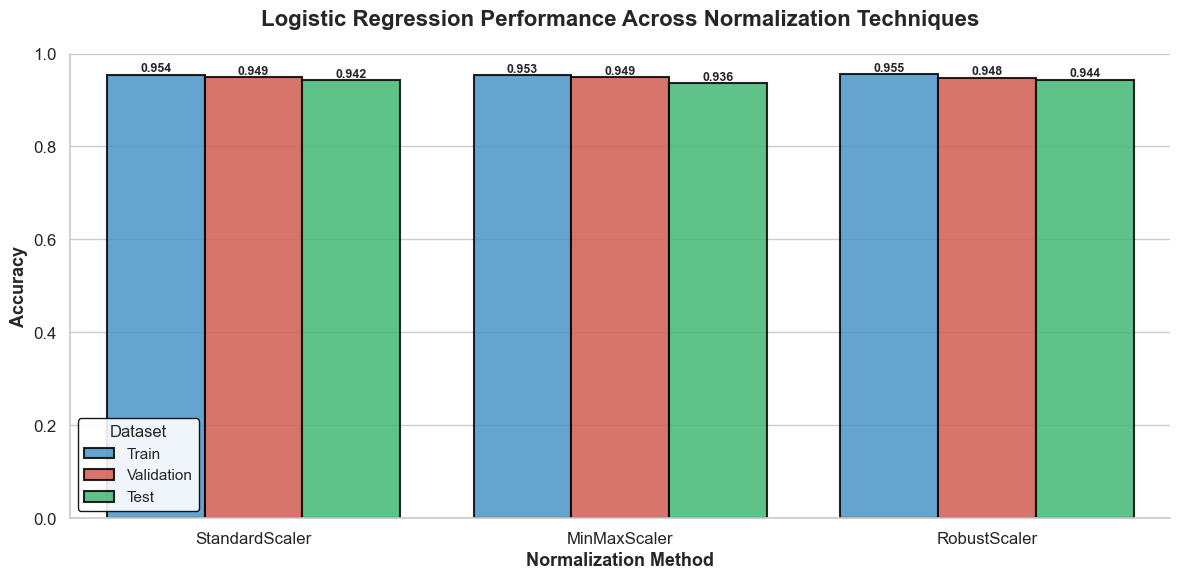


🏆 Best Normalization: RobustScaler (Test Acc: 0.9440)


In [48]:
# Compare normalization techniques on Logistic Regression
plt.close('all')

print("\n" + "="*70)
print("     📊 NORMALIZATION TECHNIQUE COMPARISON 📊")
print("="*70)

normalization_results = []

for scaler_name, X_tr, X_v, X_te in [
    ('StandardScaler', X_train_standard, X_val_standard, X_test_standard),
    ('MinMaxScaler', X_train_minmax, X_val_minmax, X_test_minmax),
    ('RobustScaler', X_train_robust, X_val_robust, X_test_robust)
]:
    # Train model with optimal C from previous analysis
    model = LogisticRegression(
        penalty='l1',
        C=best_C if 'best_C' in dir() else 1.0,
        solver='saga',
        max_iter=2000,
        random_state=42
    )
    model.fit(X_tr, y_train)
    
    # Evaluate
    train_acc = accuracy_score(y_train, model.predict(X_tr))
    val_acc = accuracy_score(y_val, model.predict(X_v))
    test_acc = accuracy_score(y_test, model.predict(X_te))
    
    normalization_results.append({
        'Scaler': scaler_name,
        'Train': train_acc,
        'Validation': val_acc,
        'Test': test_acc
    })
    
    print(f"\n{scaler_name}:")
    print(f"  Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

# Create beautiful comparison plot
results_df = pd.DataFrame(normalization_results)
results_melted = results_df.melt(id_vars='Scaler', var_name='Dataset', value_name='Accuracy')

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=results_melted, x='Scaler', y='Accuracy', hue='Dataset', 
            palette={'Train': '#3498db', 'Validation': '#e74c3c', 'Test': '#2ecc71'},
            ax=ax, edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_title('Logistic Regression Performance Across Normalization Techniques', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Normalization Method', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
sns.despine()

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=9, fontweight='bold')

ax.legend(title='Dataset', fontsize=11, title_fontsize=12, framealpha=0.9, edgecolor='black')
plt.tight_layout()
plt.show()

# Identify best scaler
best_result = results_df.loc[results_df['Test'].idxmax()]
print(f"\n🏆 Best Normalization: {best_result['Scaler']} (Test Acc: {best_result['Test']:.4f})")
print("="*70)

In [49]:
# SVM Analysis with Different Kernels
from sklearn.svm import SVC

print("\n" + "="*70)
print("     🤖 SUPPORT VECTOR MACHINE (SVM) ANALYSIS 🤖")
print("="*70)

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
C_values_svm = np.logspace(-2, 2, 30)  # Regularization parameter

# Store results for each kernel
svm_results = {kernel: {'train': [], 'val': [], 'C_values': C_values_svm} for kernel in kernels}

print("\nTraining SVM models with different kernels...")
print("This may take a few minutes...\n")

for kernel in kernels:
    print(f"Training {kernel.upper()} kernel SVM...")
    for C in C_values_svm:
        # Use StandardScaler as it's typically best for SVM
        model = SVC(
            kernel=kernel,
            C=C,
            random_state=42,
            degree=3 if kernel == 'poly' else 3,  # degree only matters for poly
            gamma='scale'  # auto-adjust based on features
        )
        
        model.fit(X_train_standard, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(X_train_standard))
        val_acc = accuracy_score(y_val, model.predict(X_val_standard))
        
        svm_results[kernel]['train'].append(train_acc)
        svm_results[kernel]['val'].append(val_acc)
    
    # Find best C for this kernel
    best_idx_kernel = np.argmax(svm_results[kernel]['val'])
    best_C_kernel = C_values_svm[best_idx_kernel]
    best_val_acc = svm_results[kernel]['val'][best_idx_kernel]
    
    print(f"  ✓ Best C: {best_C_kernel:.4f}, Val Acc: {best_val_acc:.4f}")

print("\n✅ Completed training all SVM models!")


     🤖 SUPPORT VECTOR MACHINE (SVM) ANALYSIS 🤖

Training SVM models with different kernels...
This may take a few minutes...

Training LINEAR kernel SVM...
  ✓ Best C: 0.6210, Val Acc: 0.9480
Training RBF kernel SVM...
  ✓ Best C: 1.6103, Val Acc: 0.9350
Training POLY kernel SVM...
  ✓ Best C: 3.0392, Val Acc: 0.9250
Training SIGMOID kernel SVM...
  ✓ Best C: 3.0392, Val Acc: 0.9450

✅ Completed training all SVM models!


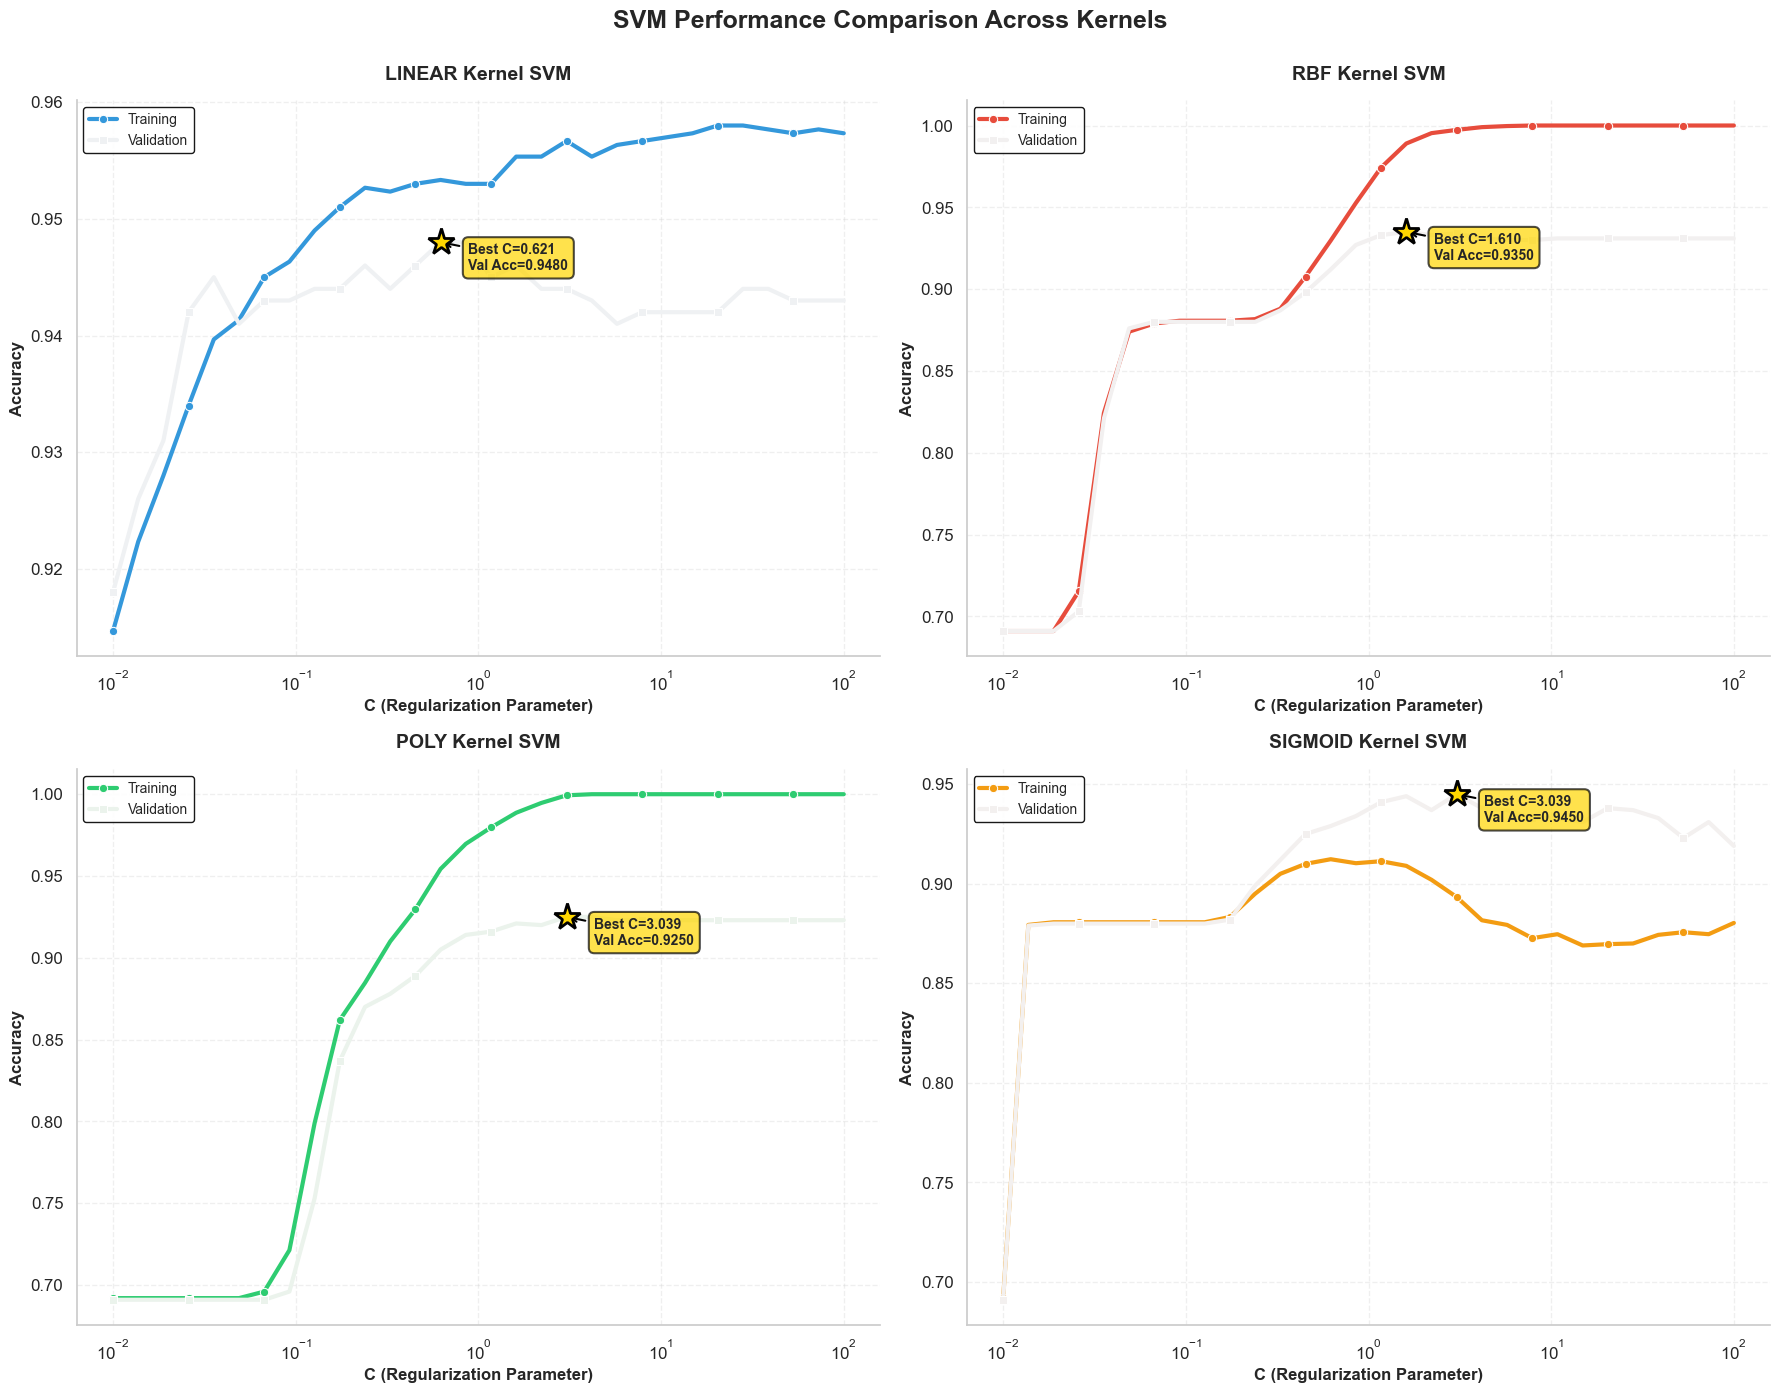


           📊 SVM KERNEL COMPARISON SUMMARY 📊

Kernel       Best C       Train Acc    Val Acc     
----------------------------------------------------------------------
linear       0.6210       0.9533       0.9480      
rbf          1.6103       0.9890       0.9350      
poly         3.0392       0.9993       0.9250      
sigmoid      3.0392       0.8933       0.9450      


In [50]:
# Visualize SVM Performance Across Different Kernels
plt.close('all')

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

kernel_colors = {
    'linear': '#3498db',
    'rbf': '#e74c3c', 
    'poly': '#2ecc71',
    'sigmoid': '#f39c12'
}

# Plot each kernel in its own subplot
for idx, kernel in enumerate(kernels):
    ax = axes[idx]
    
    # Prepare data for seaborn
    kernel_df = pd.DataFrame({
        'C': np.concatenate([C_values_svm, C_values_svm]),
        'Accuracy': np.concatenate([svm_results[kernel]['train'], svm_results[kernel]['val']]),
        'Dataset': ['Training']*len(C_values_svm) + ['Validation']*len(C_values_svm)
    })
    
    # Plot using seaborn
    sns.lineplot(data=kernel_df, x='C', y='Accuracy', hue='Dataset', style='Dataset',
                markers=['o', 's'], dashes=False, linewidth=3, markersize=6, 
                markevery=3, ax=ax,
                palette={'Training': kernel_colors[kernel], 
                        'Validation': sns.light_palette(kernel_colors[kernel], n_colors=3)[0]})
    
    ax.set_xscale('log')
    ax.set_xlabel('C (Regularization Parameter)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title(f'{kernel.upper()} Kernel SVM', fontsize=14, fontweight='bold', pad=15)
    sns.despine(ax=ax)
    
    # Mark best validation point
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    best_val_k = svm_results[kernel]['val'][best_idx_k]
    
    ax.plot(best_C_k, best_val_k, marker='*', markersize=20, 
            color='gold', markeredgecolor='black', markeredgewidth=2, zorder=10)
    
    ax.annotate(f'Best C={best_C_k:.3f}\nVal Acc={best_val_k:.4f}',
               xy=(best_C_k, best_val_k),
               xytext=(20, -20),
               textcoords='offset points',
               fontsize=10,
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='gold', alpha=0.7, edgecolor='black', linewidth=1.5),
               arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5))
    
    ax.legend(fontsize=10, framealpha=0.9, edgecolor='black')
    ax.grid(True, alpha=0.3, linestyle='--')

plt.suptitle('SVM Performance Comparison Across Kernels', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("           📊 SVM KERNEL COMPARISON SUMMARY 📊")
print("="*70)
print(f"\n{'Kernel':<12} {'Best C':<12} {'Train Acc':<12} {'Val Acc':<12}")
print("-"*70)

for kernel in kernels:
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    train_acc_k = svm_results[kernel]['train'][best_idx_k]
    val_acc_k = svm_results[kernel]['val'][best_idx_k]
    
    print(f"{kernel:<12} {best_C_k:<12.4f} {train_acc_k:<12.4f} {val_acc_k:<12.4f}")

print("="*70)


     🏆 FINAL SVM EVALUATION ON TEST SET 🏆

LINEAR Kernel (C=0.6210):
  Train: 0.9533 | Val: 0.9480 | Test: 0.9450

RBF Kernel (C=1.6103):
  Train: 0.9890 | Val: 0.9350 | Test: 0.9240

POLY Kernel (C=3.0392):
  Train: 0.9993 | Val: 0.9250 | Test: 0.9170

SIGMOID Kernel (C=3.0392):
  Train: 0.8933 | Val: 0.9450 | Test: 0.9380


/var/folders/sz/wh59dnjs4p1_q_6lrs1m0sg40000gn/T/ipykernel_81278/3712960797.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_only, y='Kernel', x='Test', palette=colors_ranked,
/var/folders/sz/wh59dnjs4p1_q_6lrs1m0sg40000gn/T/ipykernel_81278/3712960797.py:88: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/samuel/anaconda3/envs/DL/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


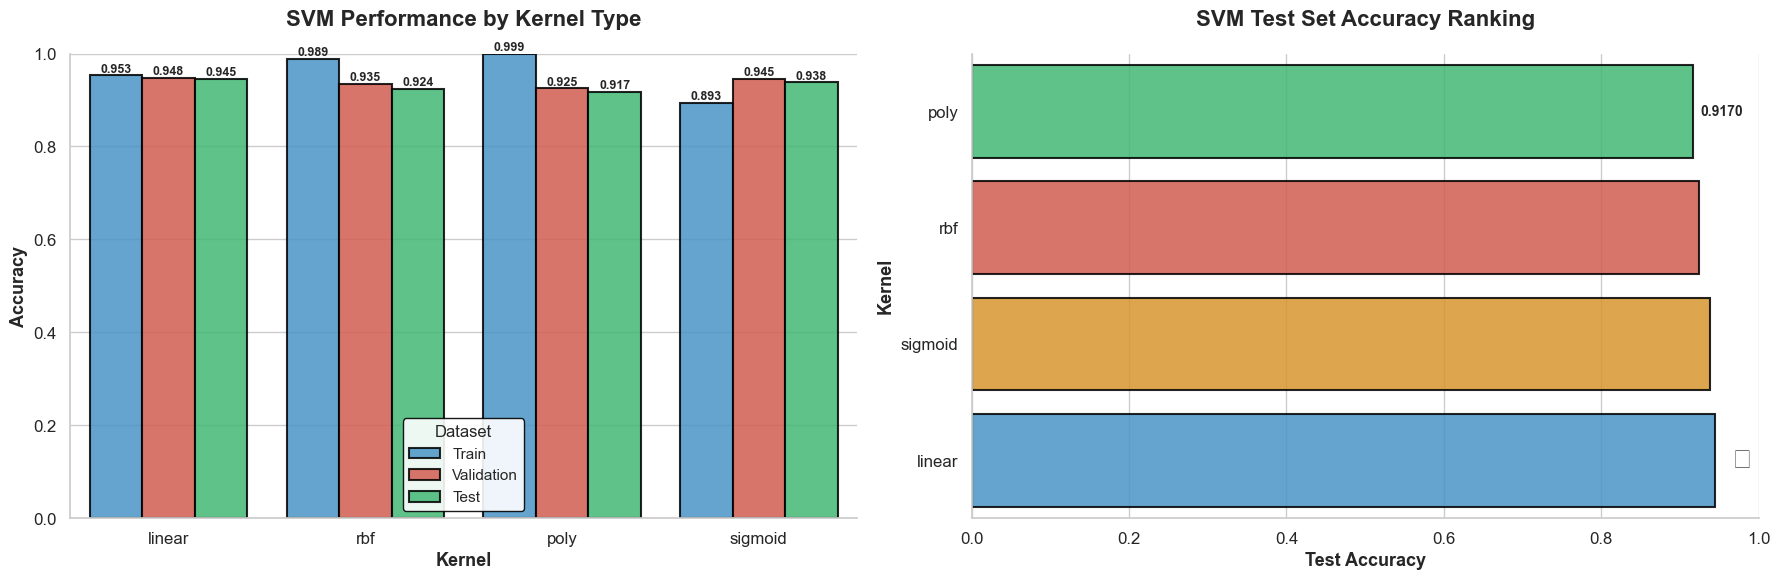


           📋 COMPLETE SVM RESULTS TABLE 📋
 Kernel        C    Train  Validation  Test
 linear 0.621017 0.953333       0.948 0.945
    rbf 1.610262 0.989000       0.935 0.924
   poly 3.039195 0.999333       0.925 0.917
sigmoid 3.039195 0.893333       0.945 0.938

🥇 BEST SVM: LINEAR Kernel (Test Acc: 0.9450)


In [51]:
# Train best SVM model and compare all kernels on test set
plt.close('all')

print("\n" + "="*70)
print("     🏆 FINAL SVM EVALUATION ON TEST SET 🏆")
print("="*70)

svm_test_results = []

for kernel in kernels:
    best_idx_k = np.argmax(svm_results[kernel]['val'])
    best_C_k = C_values_svm[best_idx_k]
    
    # Train final model with best C
    final_svm = SVC(
        kernel=kernel,
        C=best_C_k,
        random_state=42,
        degree=3,
        gamma='scale'
    )
    final_svm.fit(X_train_standard, y_train)
    
    # Evaluate on all sets
    train_acc = accuracy_score(y_train, final_svm.predict(X_train_standard))
    val_acc = accuracy_score(y_val, final_svm.predict(X_val_standard))
    test_acc = accuracy_score(y_test, final_svm.predict(X_test_standard))
    
    svm_test_results.append({
        'Kernel': kernel,
        'C': best_C_k,
        'Train': train_acc,
        'Validation': val_acc,
        'Test': test_acc
    })
    
    print(f"\n{kernel.upper()} Kernel (C={best_C_k:.4f}):")
    print(f"  Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

# Create beautiful comparison visualization
svm_test_df = pd.DataFrame(svm_test_results)
svm_test_melted = svm_test_df.melt(id_vars=['Kernel', 'C'], var_name='Dataset', value_name='Accuracy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Bar chart comparison
sns.barplot(data=svm_test_melted, x='Kernel', y='Accuracy', hue='Dataset',
           palette={'Train': '#3498db', 'Validation': '#e74c3c', 'Test': '#2ecc71'},
           ax=ax1, edgecolor='black', linewidth=1.5, alpha=0.85)

ax1.set_title('SVM Performance by Kernel Type', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Kernel', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.legend(title='Dataset', fontsize=11, title_fontsize=12, framealpha=0.9, edgecolor='black')
sns.despine(ax=ax1)

# Add value labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f', fontsize=9, fontweight='bold')

# Plot 2: Test accuracy comparison with sorted ranking
test_only = svm_test_df.sort_values('Test', ascending=True)
colors_ranked = [kernel_colors[k] for k in test_only['Kernel']]

sns.barplot(data=test_only, y='Kernel', x='Test', palette=colors_ranked,
           ax=ax2, edgecolor='black', linewidth=1.5, alpha=0.85)

ax2.set_title('SVM Test Set Accuracy Ranking', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Test Accuracy', fontsize=13, fontweight='bold')
ax2.set_ylabel('Kernel', fontsize=13, fontweight='bold')
ax2.set_xlim([0, 1])
sns.despine(ax=ax2)

# Add value labels
ax2.bar_label(ax2.containers[0], fmt='%.4f', fontsize=10, fontweight='bold', padding=5)

# Highlight best kernel
best_kernel_idx = svm_test_df['Test'].idxmax()
best_kernel = svm_test_df.loc[best_kernel_idx, 'Kernel']
best_test_acc = svm_test_df.loc[best_kernel_idx, 'Test']

# Add crown emoji to best
for i, (idx, row) in enumerate(test_only.iterrows()):
    if row['Kernel'] == best_kernel:
        ax2.text(row['Test'] + 0.02, i, '👑', fontsize=20, va='center')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("           📋 COMPLETE SVM RESULTS TABLE 📋")
print("="*70)
print(svm_test_df.to_string(index=False))
print("="*70)

print(f"\n🥇 BEST SVM: {best_kernel.upper()} Kernel (Test Acc: {best_test_acc:.4f})")
print("="*70)


     🎯 BEST SVM MODEL: LINEAR KERNEL 🎯

               📋 CLASSIFICATION REPORT (Test Set) 📋
              precision    recall  f1-score   support

           0       0.88      0.52      0.65        27
           1       0.67      0.75      0.71        85
           2       0.91      0.89      0.90       198
           3       1.00      1.00      1.00       690

    accuracy                           0.94      1000
   macro avg       0.86      0.79      0.81      1000
weighted avg       0.95      0.94      0.94      1000



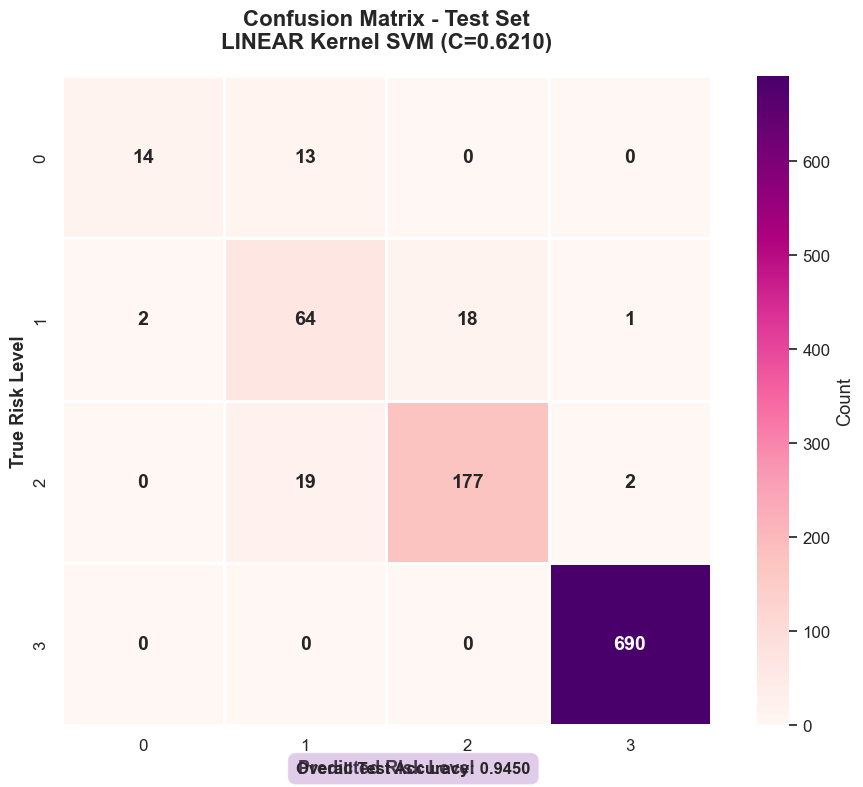

In [52]:
# Confusion Matrix for Best SVM Kernel
plt.close('all')

# Train best SVM model
best_kernel_idx = svm_test_df['Test'].idxmax()
best_svm_kernel = svm_test_df.loc[best_kernel_idx, 'Kernel']
best_svm_C = svm_test_df.loc[best_kernel_idx, 'C']

print("\n" + "="*70)
print(f"     🎯 BEST SVM MODEL: {best_svm_kernel.upper()} KERNEL 🎯")
print("="*70)

best_svm_model = SVC(
    kernel=best_svm_kernel,
    C=best_svm_C,
    random_state=42,
    degree=3,
    gamma='scale'
)
best_svm_model.fit(X_train_standard, y_train)

# Predictions
y_test_pred_svm = best_svm_model.predict(X_test_standard)

# Classification report
print("\n" + "="*70)
print("               📋 CLASSIFICATION REPORT (Test Set) 📋")
print("="*70)
print(classification_report(y_test, y_test_pred_svm))

# Beautiful confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))

cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# Use seaborn heatmap with different colormap for variety
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='RdPu', cbar_kws={'label': 'Count'}, 
            linewidths=2, linecolor='white', square=True, ax=ax,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})

ax.set_title(f'Confusion Matrix - Test Set\n{best_svm_kernel.upper()} Kernel SVM (C={best_svm_C:.4f})', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Risk Level', fontsize=13, fontweight='bold')
ax.set_ylabel('True Risk Level', fontsize=13, fontweight='bold')

# Add accuracy text
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
fig.text(0.5, 0.02, f'Overall Test Accuracy: {test_acc_svm:.4f}', 
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#9b59b6', alpha=0.3))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()